<h1><center>Bandpass Filter Parameter Estimation using PyMC</center></h1>
<h2><center>Solving the Model System in parts</center></h2>
<p>I've implemented a simplified 
</p>

In [1]:
import pymc as pm
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
exp=np.array([[16,0.3],[32,5],[64,10],[128, 20],[256 ,30],[512 , 50],[1024 , 75],[2048 , 300]])
iptg=exp[:,1]
MIC_exp=exp[:,0]

In [3]:
#defining prior distributions of our unknown variables 
constants_prob = pm.Uniform('constants_prob', 0.01, 1.0,size=10)


@pm.deterministic
def lowpass(constants_prob=constants_prob,iptg=iptg):
    bg_bla=constants_prob[0]*5000     #20/0.1 #uM/min combo of beta and gamma
    laci=constants_prob[1]*0.05       #0.01 #uM
    kd_laci=constants_prob[2]*5e-3    #7.8e-4 #uM
    n_laci=constants_prob[3]*5        #2.5
    kd_iptg=constants_prob[4]*50      #25 #uM
    n_iptg=constants_prob[5]*5        #2
    kcat=constants_prob[6]*5e6        #2.82e5 #1/m
    km=constants_prob[7]*500          #100 #uM
    ktr=constants_prob[8]*5e4         #1e3
    MIC_int=constants_prob[9]*5       #amp[0,5]
    
    
    bla=np.zeros(len(iptg))
    for i in range(len(iptg)):
        D_iptg=1+(iptg[i]/kd_iptg)**n_iptg
        D_laci=1+(laci/(kd_laci*D_iptg))**n_laci
        bla[i]=bg_bla/D_laci

    amp0=[2**i for i in range(12) ]
    amp=np.zeros((len(bla),len(amp0)))
    for i in range(len(bla)):
        for j in range(len(amp0)):
            coeff=[-ktr,(ktr*amp0[j]-ktr*km-kcat*bla[i]),ktr*amp0[j]*km]
            sol=np.roots(coeff)
            if sol[0]>=0 and sol[0]<amp0[j]:
                amp[i,j]=sol[0]
            else:
                amp[i,j]=sol[1]

    amp=amp*349.41/1000 #convert to ug/ml

    MIC_mod=np.zeros(len(iptg))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if amp[i,j]>=MIC_int:
                break
            MIC_mod[i]=amp0[j]
    return MIC_mod

In [4]:
observed_MIC = pm.Normal('observed_MIC', mu=lowpass,tau=1000,value=MIC_exp, observed=True)

In [17]:
model = pm.Model([constants_prob,lowpass,observed_MIC])
 
# fit the model with mcmc
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
constants_samples=np.zeros(10)
for i in range(10):
    mcmc.sample(5000, burn=500, thin=20)
    constants=mcmc.trace('constants_prob')[:]
    constants_samples=np.vstack((constants_samples,constants))

 [-----------------100%-----------------] 5000 of 5000 complete in 48.5 sec

In [ ]:
#MCMC samples turned to arrays
constants_samples=mcmc.trace('constants_prob')[:]

0.29355390154294919

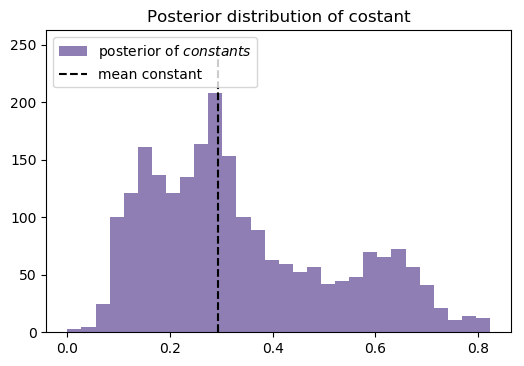

In [23]:
#Histogram of variable 1:kcat
i=4
plt.hist(constants_samples[:,i], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $constants$", color="#7A68A6");
plt.vlines(np.median(constants_samples[:,i]), 0, 250, linestyle="--", label="mean constant")
plt.legend(loc="upper left")
plt.title("Posterior distribution of costant")
np.median(constants_samples[:,i])

In [7]:
constants_samples.shape

(3901, 10)

In [11]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()